In [18]:
import pandas as pd
import numpy as np 
import io

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Important Functions 

In [2]:
np.append(np.zeros(2),[1,2])

array([0., 0., 1., 2.])

In [2]:
def stacking(groups, padding = 'left'):
    X_group = np.empty(shape=[0, max_length])
    y_group = np.empty(shape=[0, 2])
    for i in range(len(groups)):
        hash_ = np.array([[]])
        group = groups[i]
        group = group.drop('hash', axis = 1)
        for index, row in group.iterrows():
            hash_ = np.append(hash_,np.array([row[:]]))
  
        y_group = np.r_[y_group,np.array([hash_[np.shape(hash_)[0]-2:np.shape(hash_)[0]]])] # putting the output away
        hash_ = np.delete(hash_,[np.shape(hash_)[0]-2,np.shape(hash_)[0]-1]) # removing the output
  
        num_pad = max_length - np.shape(hash_)[0] # padding with 0s
        
        if padding == 'left':
            hash_ = np.append(np.zeros(num_pad),hash_) # padding left
        elif padding == 'right': 
            hash_ = np.append(hash_,np.zeros(num_pad)) # padding right
          
        X_group = np.r_[X_group,np.array([hash_])] # changing dimemsions of hash_
    return X_group, y_group


def stacking_by_chunks(df):
    df = df.drop('trajectory_id',axis = 1)
    grouped = df.groupby('hash')
    X = np.empty(shape=[0, max_length])
    y = np.empty(shape=[0, 2])  
    num_groups = grouped['hash'].unique().count()
    num_iter = 100
    chunk_size = int(num_groups/num_iter)
    #last_chunk = num_groups - chunk_size*num_iter
    
    for i in range(1,num_iter+1):
        groups = [g[1] for g in list(grouped)[(i-1)*chunk_size:i*chunk_size]]
        X_group, y_group = stacking(groups)
        X = np.r_[X,X_group]
        y = np.r_[y,y_group]
    
    groups = [g[1] for g in list(grouped)[num_iter*chunk_size:num_groups]] 
    #last chunk
    X_group, y_group = stacking(groups)
    X = np.r_[X,X_group]
    y = np.r_[y,y_group]
    
    return X,y


def stacking_no_y(groups, padding = 'left'):
    X_group = np.empty(shape=[0, max_length])
    for i in range(len(groups)):
        hash_ = np.array([[]])
        group = groups[i]
        group = group.drop('hash', axis = 1)
        for index, row in group.iterrows():
            hash_ = np.append(hash_,np.array([row[:]]))

        num_pad = max_length - np.shape(hash_)[0] # padding with 0s
        
        if padding == 'left':
            hash_ = np.append(np.zeros(num_pad),hash_) # padding left
        elif padding == 'right': 
            hash_ = np.append(hash_,np.zeros(num_pad)) # padding right
          
        X_group = np.r_[X_group,np.array([hash_])] # changing dimemsions of hash_
    return X_group


def stacking_by_chunks_no_y(df):
    df = df.drop('trajectory_id',axis = 1)
    grouped = df.groupby('hash')
    X = np.empty(shape=[0, max_length])
    num_groups = grouped['hash'].unique().count()
    num_iter = 100
    chunk_size = int(num_groups/num_iter)
    #last_chunk = num_groups - chunk_size*num_iter
    
    for i in range(1,num_iter+1):
        groups = [g[1] for g in list(grouped)[(i-1)*chunk_size:i*chunk_size]]
        X_group = stacking_no_y(groups)
        X = np.r_[X,X_group]
    
    groups = [g[1] for g in list(grouped)[num_iter*chunk_size:num_groups]] 
    #last chunk
    X_group = stacking_no_y(groups)
    X = np.r_[X,X_group]    
    return X


def city(y,bonus=[0,0]):
    city = np.array([[]])
    bonus = bonus 
    for i in range(np.shape(y)[0]):
        if y[i][0] > 3750901.5068-bonus[0] and y[i][0] < 3770901.5068+bonus[0] and y[i][1] > -19268905.6133-bonus[1] and y[i][1] < -19208905.6133+bonus[1]:
            city = np.append(city,1)
        else:
            city = np.append(city,0)
    return city  



# Loading data

In [38]:
df_train = pd.read_csv('data_train_mod.csv',index_col=0)
df_test = pd.read_csv('data_test_mod.csv',index_col=0)
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

In [3]:
X_train_all = pd.read_csv('X_train_left.csv',index_col=0) # pd.read_csv('X_train.csv',index_col=0)
y_train_all = pd.read_csv('y_train_left.csv',index_col=0) # pd.read_csv('y_train.csv',index_col=0)
X_test = pd.read_csv('X_test_left.csv',index_col=0)
X_train_all = pd.DataFrame(X_train_all)
y_train_all = pd.DataFrame(y_train_all)
X_test = pd.DataFrame(X_test)

In [4]:
print(X_test.shape)
print(X_train_all.shape)
print(y_train_all.shape)

(33515, 198)
(134063, 198)
(134063, 2)


# padding

In [5]:
# padding traning data on left
max_length = max(df_train.groupby("hash").nunique()["trajectory_id"])*10-2

X_train_left, y_train_left = stacking_by_chunks(df_train)
X_train_left = pd.DataFrame(X_train_left)
y_train_left = pd.DataFrame(y_train_left)
X_train_left.to_csv('X_train_left.csv')
y_train_left.to_csv('y_train_left.csv')

NameError: name 'X_train' is not defined

In [47]:
# padding testing data on left
max_length = max(df_test.groupby("hash").nunique()["trajectory_id"])*10

X_test_left = stacking_by_chunks_no_y(df_test)
X_test_left = pd.DataFrame(X_test_left)
X_test_left.to_csv('X_test_left.csv')

# KNN

In [81]:
# not effective for large dataset
X_train_knn = pd.DataFrame(X_train_all.loc[0:2000])
y_train_knn = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_knn)[0])
test_size = np.shape(X_train_knn)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_knn, y_train_knn, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multiknn = MultiOutputRegressor(KNeighborsRegressor())
regr_multiknn.fit(X_train, y_train)
# Predict on new data
y_multiknn = regr_multiknn.predict(X_test)

             precision    recall  f1-score   support

        0.0   0.887500  0.747368  0.811429       285
        1.0   0.552795  0.767241  0.642599       116

avg / total   0.790678  0.753117  0.762590       401

[[213  72]
 [ 27  89]]
0.7531172069825436


<Figure size 432x288 with 0 Axes>

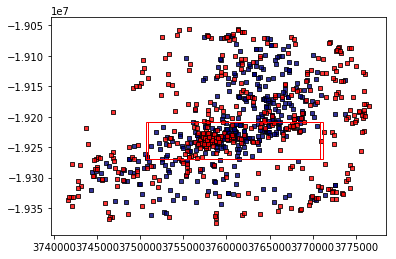

In [88]:
# accuracy 
y_test = np.array(y_test)
a = 250
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multiknn,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multiknn,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multiknn,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multiknn[:, 0], y_multiknn[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# decision tree

In [89]:
# not effective for large dataset
X_train_dt = pd.DataFrame(X_train_all.loc[0:2000])
y_train_dt = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_dt)[0])
test_size = np.shape(X_train_dt)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_dt, y_train_dt, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multidt = MultiOutputRegressor(DecisionTreeRegressor(random_state=0))
regr_multidt.fit(X_train, y_train)
# Predict on new data
y_multidt = regr_multidt.predict(X_test)

             precision    recall  f1-score   support

        0.0   0.927536  0.898246  0.912656       285
        1.0   0.768000  0.827586  0.796680       116

avg / total   0.881386  0.877805  0.879107       401

[[256  29]
 [ 20  96]]
0.8778054862842892


<Figure size 432x288 with 0 Axes>

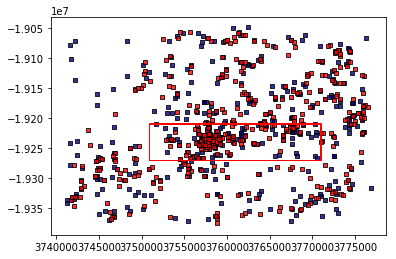

In [98]:
# accuracy 
y_test = np.array(y_test)
a = 100
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multidt,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multidt,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multidt,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multidt[:, 0], y_multidt[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# AdaBoostRegressor

In [99]:
# not effective for large dataset
X_train_ab = pd.DataFrame(X_train_all.loc[0:2000])
y_train_ab = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_ab)[0])
test_size = np.shape(X_train_ab)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_ab, y_train_ab, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multiab = MultiOutputRegressor(AdaBoostRegressor(n_estimators=200,random_state=0))
regr_multiab.fit(X_train, y_train)
# Predict on new data
y_multiab = regr_multiab.predict(X_test)

             precision    recall  f1-score   support

        0.0   0.843750  0.757895  0.798521       285
        1.0   0.524138  0.655172  0.582375       116

avg / total   0.751294  0.728180  0.735995       401

[[216  69]
 [ 40  76]]
0.7281795511221946


<Figure size 432x288 with 0 Axes>

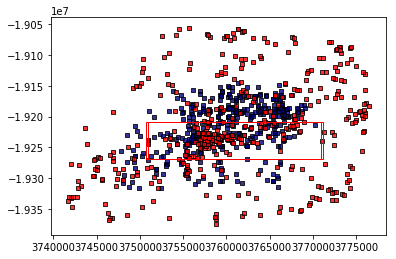

In [107]:
# accuracy 
y_test = np.array(y_test)
a = 200
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multiab,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multiab,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multiab,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multiab[:, 0], y_multiab[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# ExtraTreesRegressor

In [108]:
# not effective for large dataset
X_train_et = pd.DataFrame(X_train_all.loc[0:2000])
y_train_et = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_et)[0])
test_size = np.shape(X_train_et)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_et, y_train_et, train_size=train_size, test_size=test_size, random_state=4)

# extra tree
regr_multiet = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=200,max_depth=100,random_state=0,verbose=True))
regr_multiet.fit(X_train, y_train)
# Predict on new data
y_multiet = regr_multiet.predict(X_test)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


             precision    recall  f1-score   support

        0.0   0.965385  0.880702  0.921101       285
        1.0   0.758865  0.922414  0.832685       116

avg / total   0.905643  0.892768  0.895524       401

[[251  34]
 [  9 107]]
0.8927680798004988


<Figure size 432x288 with 0 Axes>

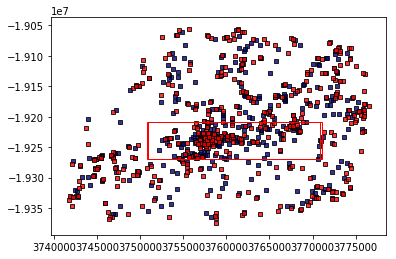

In [118]:
# accuracy 
y_test = np.array(y_test)
a = 150
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multiet,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multiet,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multiet,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multiet[:, 0], y_multiet[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# SVR

In [22]:
# not effective for large dataset
X_train_svr = pd.DataFrame(X_train_all.loc[0:2000])
y_train_svr = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_svr)[0])
test_size = np.shape(X_train_svr)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_svr, y_train_svr, train_size=train_size, test_size=test_size, random_state=4)

#grid search
pipe_svr = Pipeline([('scl', StandardScaler()),
        ('reg', MultiOutputRegressor(SVR()))])

grid_param_svr = {
    'reg__estimator__C': [0.1,1,10]
}

gs_svr = (GridSearchCV(estimator=pipe_svr, 
                      param_grid=grid_param_svr, 
                      cv=2,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_svr = gs_svr.fit(X_train,y_train)
gs_svr.best_estimator_    

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), 
('reg', MultiOutputRegressor(estimator=SVR(C=10, cache_size=200,
 coef0=0.0, degree=3, epsilon=0.1, gamma='auto', kernel='rbf', max_iter=-1,    
 shrinking=True, tol=0.001, verbose=False), n_jobs=1))])

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', MultiOutputRegressor(estimator=SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1))])

In [23]:
# svr
regr_multisvr = MultiOutputRegressor(estimator=SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1)
regr_multisvr.fit(X_train, y_train)
# Predict on new data
y_multisvr = regr_multisvr.predict(X_test)

             precision    recall  f1-score   support

        0.0   0.000000  0.000000  0.000000       285
        1.0   0.289277  1.000000  0.448743       116

avg / total   0.083681  0.289277  0.129811       401

[[  0 285]
 [  0 116]]
0.2892768079800499


/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

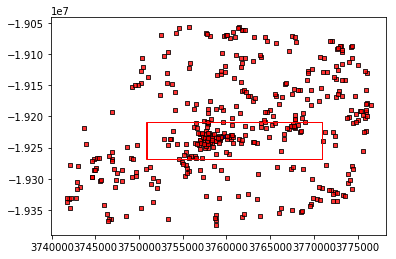

In [24]:
# accuracy 
y_test = np.array(y_test)
a = 60
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multisvr,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multisvr,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multisvr,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multisvr[:, 0], y_multisvr[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# random forest

In [5]:
# not effective for large dataset
X_train_rf = pd.DataFrame(X_train_all.loc[0:2000])
y_train_rf = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_rf)[0])
test_size = np.shape(X_train_rf)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_rf, y_train_rf, train_size=train_size, test_size=test_size, random_state=4)

# random forest
# n_estimators=222,max_depth=66,min_samples_leaf=4,min_samples_split=5,verbose=True
# n_estimators=250,max_depth=None,min_samples_leaf=7,min_samples_split=14,verbose=True, a=250
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=250,max_depth=None,min_samples_leaf=7,min_samples_split=14,verbose=True,n_jobs=-1))
regr_multirf.fit(X_train, y_train)
# Predict on new data
y_multirf = regr_multirf.predict(X_test)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.1s finished


In [10]:
print(np.shape(y_multirf))
print(np.shape(X_test))
print(X_train.shape)
print(y_train.shape)

(401, 2)
(401, 198)
(1600, 198)
(1600, 2)


             precision    recall  f1-score   support

        0.0   0.966038  0.898246  0.930909       285
        1.0   0.786765  0.922414  0.849206       116

avg / total   0.914178  0.905237  0.907274       401

[[256  29]
 [  9 107]]
0.9052369077306733


<Figure size 432x288 with 0 Axes>

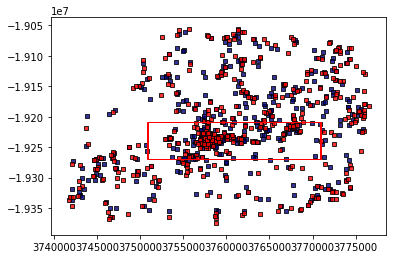

In [7]:
# accuracy 
y_test = np.array(y_test)
a = 60
bonus = [a,3*a]
print (classification_report(city(y_test,bonus=[0,0]), city(y_multirf,bonus=bonus),digits = 6))
print (confusion_matrix(city(y_test,bonus=[0,0]), city(y_multirf,bonus=bonus)))
print (accuracy_score(city(y_test,bonus=[0,0]), city(y_multirf,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

In [287]:
a = 60
result = pd.DataFrame(city(y_multirf,bonus = [a,3*a]))

hash_names = pd.DataFrame(pd.read_csv('data_test.csv'))
hash_names = hash_names[hash_names["x_exit"].isna()]["trajectory_id"]
hash_names = pd.DataFrame(hash_names).values.flatten()
hash_names = pd.DataFrame(hash_names)

results = pd.concat([hash_names, result],axis =1)
results.to_csv('Final_Results.csv')
results.head()

,0,0
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0.0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0.0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1.0
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0.0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0.0


# gradient boosting

In [130]:
# 
X_train_gb = pd.DataFrame(X_train_all.loc[0:2000])
y_train_gb = pd.DataFrame(y_train_all.loc[0:2000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_gb)[0])
test_size = np.shape(X_train_gb)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_gb, y_train_gb, train_size=train_size, test_size=test_size, random_state=4)

# gradient boosting 
regr_multigbr = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100,max_depth=20,random_state=0,verbose=True))
regr_multigbr.fit(X_train, y_train)
# Predict on new data
y_multigbr = regr_multigbr.predict(X_test)


      Iter       Train Loss   Remaining Time 
         1    70978679.0528           37.20s
         2    57492934.8609           36.92s
         3    46569475.2554           36.61s
         4    37721439.7179           36.20s
         5    30554527.8493           35.90s
         6    24749286.4189           35.44s
         7    20046990.5884           35.09s
         8    16238121.2410           34.72s
         9    13152932.3717           34.35s
        10    10653918.6206           33.99s
        20     1295358.7902           30.41s
        30      157504.4694           26.66s
        40       19151.1244           22.78s
        50        2328.7089           18.99s
        60         283.2119           15.20s
        70          34.4470           11.41s
        80           4.1898            7.61s
        90           0.5095            3.81s
       100           0.0620            0.00s
      Iter       Train Loss   Remaining Time 
         1  4892743805.3133           31.18s
        

             precision    recall  f1-score   support

        0.0     0.9341    0.8947    0.9140       285
        1.0     0.7656    0.8448    0.8033       116

avg / total     0.8853    0.8803    0.8820       401

[[255  30]
 [ 18  98]]
0.8802992518703242


<Figure size 432x288 with 0 Axes>

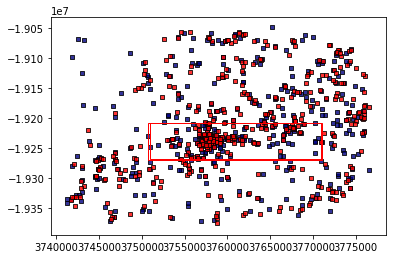

In [144]:
# accuracy 
y_test = np.array(y_test)
a = 150
bonus = [a,3*a]
print (classification_report(city(y_test), city(y_multigbr,bonus=bonus),digits = 4))
print (confusion_matrix(city(y_test), city(y_multigbr,bonus=bonus)))
print (accuracy_score(city(y_test), city(y_multigbr,bonus=bonus)))

# plotting 
plt.figure()
s = 20
a = 0.8
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_multigbr[:, 0], y_multigbr[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
y_test = np.array(y_test)
ax.scatter(y_test[:, 0], y_test[:, 1], edgecolor='k',
            c="red", s=s, marker="s", alpha=a, label="Data")
rect1 = patches.Rectangle((3750901.5068,-19268905.6133),20000,60000,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((3750901.5068-bonus[0],-19268905.6133-bonus[1]),20000+2*bonus[0],60000+2*bonus[1],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.show()

# minibatch SGDClassifier - no good at all

In [74]:
X_train_SGD = pd.DataFrame(X_train_all)
y_train_SGD = pd.DataFrame(y_train_all)
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_SGD)[0])
test_size = np.shape(X_train_SGD)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_SGD, y_train_SGD, train_size=train_size, test_size=test_size, random_state=4)

regr_SGD = linear_model.SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,verbose = True)

regr_SGD.fit(X_train, city(np.array(y_train),bonus=[500,2000]))
# Predict on new data
y_SGD = regr_SGD.predict(X_test)


-- Epoch 1
Norm: 27095291.64, NNZs: 195, Bias: -14.855364, T: 107250, Avg. loss: 392839284198682.375000
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 21597848.45, NNZs: 195, Bias: -16.169981, T: 214500, Avg. loss: 58003719648532.179688
Total training time: 0.23 seconds.
-- Epoch 3
Norm: 20039950.67, NNZs: 195, Bias: -16.858357, T: 321750, Avg. loss: 33970955876032.894531
Total training time: 0.34 seconds.
-- Epoch 4
Norm: 19285786.25, NNZs: 195, Bias: -17.303465, T: 429000, Avg. loss: 23962708274755.816406
Total training time: 0.46 seconds.
-- Epoch 5
Norm: 19137339.61, NNZs: 195, Bias: -17.674602, T: 536250, Avg. loss: 18615709622954.464844
Total training time: 0.58 seconds.
-- Epoch 6
Norm: 18781571.92, NNZs: 195, Bias: -17.964002, T: 643500, Avg. loss: 15226856372517.259766
Total training time: 0.70 seconds.
-- Epoch 7
Norm: 18465105.71, NNZs: 195, Bias: -18.224214, T: 750750, Avg. loss: 12906801549322.269531
Total training time: 0.81 seconds.
-- Epoch 8
Norm: 18157591.88, NNZ

Norm: 9657732.72, NNZs: 195, Bias: -20.886973, T: 6435000, Avg. loss: 1398426382377.162354
Total training time: 6.89 seconds.
-- Epoch 61
Norm: 9551117.76, NNZs: 195, Bias: -20.899281, T: 6542250, Avg. loss: 1374697619619.526367
Total training time: 7.01 seconds.
-- Epoch 62
Norm: 9450301.76, NNZs: 195, Bias: -20.908366, T: 6649500, Avg. loss: 1350896502781.951416
Total training time: 7.13 seconds.
-- Epoch 63
Norm: 9360488.07, NNZs: 195, Bias: -20.924751, T: 6756750, Avg. loss: 1324892364126.022461
Total training time: 7.25 seconds.
-- Epoch 64
Norm: 9255730.10, NNZs: 195, Bias: -20.932087, T: 6864000, Avg. loss: 1308321195638.014404
Total training time: 7.37 seconds.
-- Epoch 65
Norm: 9149142.86, NNZs: 195, Bias: -20.945106, T: 6971250, Avg. loss: 1290096621076.104248
Total training time: 7.48 seconds.
-- Epoch 66
Norm: 9047121.71, NNZs: 195, Bias: -20.957896, T: 7078500, Avg. loss: 1271524079072.055664
Total training time: 7.59 seconds.
-- Epoch 67
Norm: 8959444.96, NNZs: 195, Bias:

Norm: 5800923.29, NNZs: 195, Bias: -21.363431, T: 12870000, Avg. loss: 691408232848.581787
Total training time: 13.73 seconds.
-- Epoch 121
Norm: 5767732.23, NNZs: 195, Bias: -21.368060, T: 12977250, Avg. loss: 688074546907.242554
Total training time: 13.84 seconds.
-- Epoch 122
Norm: 5718625.34, NNZs: 195, Bias: -21.371892, T: 13084500, Avg. loss: 682303560182.999023
Total training time: 13.95 seconds.
-- Epoch 123
Norm: 5682538.57, NNZs: 195, Bias: -21.377218, T: 13191750, Avg. loss: 677172474297.022949
Total training time: 14.05 seconds.
-- Epoch 124
Norm: 5641405.32, NNZs: 195, Bias: -21.382499, T: 13299000, Avg. loss: 673257920459.613647
Total training time: 14.16 seconds.
-- Epoch 125
Norm: 5607360.72, NNZs: 195, Bias: -21.387737, T: 13406250, Avg. loss: 667654798005.918457
Total training time: 14.27 seconds.
-- Epoch 126
Norm: 5574144.56, NNZs: 195, Bias: -21.392935, T: 13513500, Avg. loss: 661825685081.770752
Total training time: 14.38 seconds.
-- Epoch 127
Norm: 5533275.21, NN

Norm: 4140168.88, NNZs: 195, Bias: -21.613216, T: 19305000, Avg. loss: 460813382064.956055
Total training time: 20.82 seconds.
-- Epoch 181
Norm: 4127045.78, NNZs: 195, Bias: -21.616835, T: 19412250, Avg. loss: 460083818826.907776
Total training time: 20.95 seconds.
-- Epoch 182
Norm: 4108295.78, NNZs: 195, Bias: -21.620432, T: 19519500, Avg. loss: 458659669940.061401
Total training time: 21.06 seconds.
-- Epoch 183
Norm: 4083966.74, NNZs: 195, Bias: -21.623498, T: 19626750, Avg. loss: 455962325023.839722
Total training time: 21.18 seconds.
-- Epoch 184
Norm: 4071773.25, NNZs: 195, Bias: -21.627562, T: 19734000, Avg. loss: 453504683627.116821
Total training time: 21.31 seconds.
-- Epoch 185
Norm: 4057785.45, NNZs: 195, Bias: -21.632108, T: 19841250, Avg. loss: 450263352947.818787
Total training time: 21.43 seconds.
-- Epoch 186
Norm: 4040484.83, NNZs: 195, Bias: -21.634115, T: 19948500, Avg. loss: 443618008126.074097
Total training time: 21.55 seconds.
-- Epoch 187
Norm: 4023169.71, NN

Norm: 3278712.32, NNZs: 195, Bias: -21.789646, T: 25740000, Avg. loss: 347785930320.520264
Total training time: 27.72 seconds.
-- Epoch 241
Norm: 3271490.63, NNZs: 195, Bias: -21.791975, T: 25847250, Avg. loss: 344707808211.376282
Total training time: 27.84 seconds.
-- Epoch 242
Norm: 3261490.90, NNZs: 195, Bias: -21.795451, T: 25954500, Avg. loss: 343008376433.894348
Total training time: 27.95 seconds.
-- Epoch 243
Norm: 3250872.64, NNZs: 195, Bias: -21.798525, T: 26061750, Avg. loss: 342599845702.897278
Total training time: 28.07 seconds.
-- Epoch 244
Norm: 3235762.96, NNZs: 195, Bias: -21.799673, T: 26169000, Avg. loss: 339669261263.641418
Total training time: 28.18 seconds.
-- Epoch 245
Norm: 3225284.31, NNZs: 195, Bias: -21.802342, T: 26276250, Avg. loss: 339181573911.130127
Total training time: 28.30 seconds.
-- Epoch 246
Norm: 3213092.59, NNZs: 195, Bias: -21.804619, T: 26383500, Avg. loss: 337441578149.497192
Total training time: 28.42 seconds.
-- Epoch 247
Norm: 3198268.26, NN

Norm: 2716173.11, NNZs: 195, Bias: -21.924852, T: 32175000, Avg. loss: 277589865108.085938
Total training time: 34.38 seconds.
-- Epoch 301
Norm: 2711473.11, NNZs: 195, Bias: -21.927333, T: 32282250, Avg. loss: 275337928922.366638
Total training time: 34.49 seconds.
-- Epoch 302
Norm: 2703217.58, NNZs: 195, Bias: -21.928260, T: 32389500, Avg. loss: 276658775100.152161
Total training time: 34.59 seconds.
-- Epoch 303
Norm: 2697791.90, NNZs: 195, Bias: -21.931035, T: 32496750, Avg. loss: 274559688037.602081
Total training time: 34.70 seconds.
-- Epoch 304
Norm: 2689534.32, NNZs: 195, Bias: -21.932878, T: 32604000, Avg. loss: 275044424446.100769
Total training time: 34.81 seconds.
-- Epoch 305
Norm: 2682456.79, NNZs: 195, Bias: -21.934714, T: 32711250, Avg. loss: 272471401110.599335
Total training time: 34.91 seconds.
-- Epoch 306
Norm: 2676533.15, NNZs: 195, Bias: -21.936241, T: 32818500, Avg. loss: 271428241043.799469
Total training time: 35.02 seconds.
-- Epoch 307
Norm: 2670453.75, NN

Norm: 2313222.84, NNZs: 195, Bias: -22.034722, T: 38610000, Avg. loss: 230119495576.020691
Total training time: 41.19 seconds.
-- Epoch 361
Norm: 2306662.59, NNZs: 195, Bias: -22.036274, T: 38717250, Avg. loss: 229788475324.456696
Total training time: 41.30 seconds.
-- Epoch 362
Norm: 2305371.92, NNZs: 195, Bias: -22.037821, T: 38824500, Avg. loss: 229349518273.265503
Total training time: 41.42 seconds.
-- Epoch 363
Norm: 2298897.36, NNZs: 195, Bias: -22.039109, T: 38931750, Avg. loss: 229545020176.432037
Total training time: 41.54 seconds.
-- Epoch 364
Norm: 2295760.28, NNZs: 195, Bias: -22.041161, T: 39039000, Avg. loss: 228133987204.624817
Total training time: 41.66 seconds.
-- Epoch 365
Norm: 2287623.33, NNZs: 195, Bias: -22.042696, T: 39146250, Avg. loss: 227696291307.965515
Total training time: 41.78 seconds.
-- Epoch 366
Norm: 2283524.46, NNZs: 195, Bias: -22.044992, T: 39253500, Avg. loss: 229070620209.570343
Total training time: 41.90 seconds.
-- Epoch 367
Norm: 2278991.52, NN

Norm: 2041556.71, NNZs: 195, Bias: -22.128405, T: 45045000, Avg. loss: 197802065254.479218
Total training time: 48.19 seconds.
-- Epoch 421
Norm: 2037716.90, NNZs: 195, Bias: -22.129514, T: 45152250, Avg. loss: 198098748770.645172
Total training time: 48.31 seconds.
-- Epoch 422
Norm: 2036841.05, NNZs: 195, Bias: -22.131505, T: 45259500, Avg. loss: 195775673936.504883
Total training time: 48.42 seconds.
-- Epoch 423
Norm: 2031016.05, NNZs: 195, Bias: -22.133049, T: 45366750, Avg. loss: 197035298736.873810
Total training time: 48.54 seconds.
-- Epoch 424
Norm: 2028178.11, NNZs: 195, Bias: -22.134150, T: 45474000, Avg. loss: 196050090321.061646
Total training time: 48.67 seconds.
-- Epoch 425
Norm: 2026259.83, NNZs: 195, Bias: -22.136345, T: 45581250, Avg. loss: 195828073321.115204
Total training time: 48.78 seconds.
-- Epoch 426
Norm: 2020996.86, NNZs: 195, Bias: -22.137003, T: 45688500, Avg. loss: 195846565860.534241
Total training time: 48.90 seconds.
-- Epoch 427
Norm: 2017856.32, NN

Norm: 1834624.10, NNZs: 195, Bias: -22.209761, T: 51480000, Avg. loss: 172807478821.210876
Total training time: 55.16 seconds.
-- Epoch 481
Norm: 1831560.03, NNZs: 195, Bias: -22.210925, T: 51587250, Avg. loss: 173322036019.646210
Total training time: 55.27 seconds.
-- Epoch 482
Norm: 1828397.30, NNZs: 195, Bias: -22.212280, T: 51694500, Avg. loss: 173295783635.791962
Total training time: 55.39 seconds.
-- Epoch 483
Norm: 1825053.54, NNZs: 195, Bias: -22.213632, T: 51801750, Avg. loss: 171609721095.584106
Total training time: 55.51 seconds.
-- Epoch 484
Norm: 1823606.01, NNZs: 195, Bias: -22.214596, T: 51909000, Avg. loss: 170793322660.658173
Total training time: 55.63 seconds.
-- Epoch 485
Norm: 1820067.64, NNZs: 195, Bias: -22.215558, T: 52016250, Avg. loss: 171072175409.304871
Total training time: 55.74 seconds.
-- Epoch 486
Norm: 1818359.58, NNZs: 195, Bias: -22.216903, T: 52123500, Avg. loss: 171505906397.780304
Total training time: 55.86 seconds.
-- Epoch 487
Norm: 1813414.58, NN

Norm: 1662628.27, NNZs: 195, Bias: -22.281490, T: 57915000, Avg. loss: 152888855321.673279
Total training time: 61.92 seconds.
-- Epoch 541
Norm: 1660251.08, NNZs: 195, Bias: -22.282698, T: 58022250, Avg. loss: 152953003302.888123
Total training time: 62.03 seconds.
-- Epoch 542
Norm: 1659555.40, NNZs: 195, Bias: -22.283904, T: 58129500, Avg. loss: 152773888508.574890
Total training time: 62.13 seconds.
-- Epoch 543
Norm: 1657066.76, NNZs: 195, Bias: -22.284935, T: 58236750, Avg. loss: 153886074890.297363
Total training time: 62.24 seconds.
-- Epoch 544
Norm: 1653828.08, NNZs: 195, Bias: -22.286307, T: 58344000, Avg. loss: 153681915824.010284
Total training time: 62.34 seconds.
-- Epoch 545
Norm: 1652657.99, NNZs: 195, Bias: -22.287677, T: 58451250, Avg. loss: 152586482461.035706
Total training time: 62.46 seconds.
-- Epoch 546
Norm: 1648491.64, NNZs: 195, Bias: -22.288360, T: 58558500, Avg. loss: 151527060496.129639
Total training time: 62.58 seconds.
-- Epoch 547
Norm: 1645330.59, NN

Norm: 1531540.64, NNZs: 195, Bias: -22.345488, T: 64350000, Avg. loss: 138315423375.704102
Total training time: 68.65 seconds.
-- Epoch 601
Norm: 1529047.10, NNZs: 195, Bias: -22.345954, T: 64457250, Avg. loss: 138700962741.210510
Total training time: 68.76 seconds.
-- Epoch 602
Norm: 1525406.14, NNZs: 195, Bias: -22.347194, T: 64564500, Avg. loss: 137455426570.601715
Total training time: 68.88 seconds.
-- Epoch 603
Norm: 1524242.61, NNZs: 195, Bias: -22.347968, T: 64671750, Avg. loss: 137216250707.168915
Total training time: 68.99 seconds.
-- Epoch 604
Norm: 1521702.77, NNZs: 195, Bias: -22.349049, T: 64779000, Avg. loss: 137716548795.124908
Total training time: 69.11 seconds.
-- Epoch 605
Norm: 1519448.74, NNZs: 195, Bias: -22.350129, T: 64886250, Avg. loss: 138326109045.949982
Total training time: 69.23 seconds.
-- Epoch 606
Norm: 1517528.67, NNZs: 195, Bias: -22.351053, T: 64993500, Avg. loss: 137897559570.704041
Total training time: 69.35 seconds.
-- Epoch 607
Norm: 1514795.57, NN

Norm: 1416945.00, NNZs: 195, Bias: -22.401897, T: 70785000, Avg. loss: 125331334014.445755
Total training time: 75.39 seconds.
-- Epoch 661
Norm: 1416888.48, NNZs: 195, Bias: -22.402602, T: 70892250, Avg. loss: 125709165619.772949
Total training time: 75.51 seconds.
-- Epoch 662
Norm: 1414005.98, NNZs: 195, Bias: -22.403871, T: 70999500, Avg. loss: 125424089381.079727
Total training time: 75.63 seconds.
-- Epoch 663
Norm: 1411597.98, NNZs: 195, Bias: -22.404293, T: 71106750, Avg. loss: 125208759074.215607
Total training time: 75.75 seconds.
-- Epoch 664
Norm: 1409252.90, NNZs: 195, Bias: -22.405136, T: 71214000, Avg. loss: 125628727715.554535
Total training time: 75.86 seconds.
-- Epoch 665
Norm: 1408090.30, NNZs: 195, Bias: -22.405978, T: 71321250, Avg. loss: 124766700749.313553
Total training time: 75.98 seconds.
-- Epoch 666
Norm: 1405678.62, NNZs: 195, Bias: -22.407099, T: 71428500, Avg. loss: 125200787339.732788
Total training time: 76.10 seconds.
-- Epoch 667
Norm: 1405405.98, NN

Norm: 1316869.26, NNZs: 195, Bias: -22.454060, T: 77220000, Avg. loss: 115161192612.060516
Total training time: 82.19 seconds.
-- Epoch 721
Norm: 1316668.80, NNZs: 195, Bias: -22.454578, T: 77327250, Avg. loss: 115018826732.788986
Total training time: 82.30 seconds.
-- Epoch 722
Norm: 1314184.57, NNZs: 195, Bias: -22.455353, T: 77434500, Avg. loss: 115953499449.031036
Total training time: 82.41 seconds.
-- Epoch 723
Norm: 1311547.39, NNZs: 195, Bias: -22.455999, T: 77541750, Avg. loss: 114257117031.519211
Total training time: 82.51 seconds.
-- Epoch 724
Norm: 1309664.61, NNZs: 195, Bias: -22.456643, T: 77649000, Avg. loss: 115049348533.284393
Total training time: 82.62 seconds.
-- Epoch 725
Norm: 1307333.78, NNZs: 195, Bias: -22.457930, T: 77756250, Avg. loss: 114703472392.932098
Total training time: 82.73 seconds.
-- Epoch 726
Norm: 1306698.92, NNZs: 195, Bias: -22.458187, T: 77863500, Avg. loss: 114273493656.648407
Total training time: 82.83 seconds.
-- Epoch 727
Norm: 1304629.10, NN

Norm: 1239331.37, NNZs: 195, Bias: -22.501919, T: 83655000, Avg. loss: 106533849197.113678
Total training time: 88.78 seconds.
-- Epoch 781
Norm: 1238663.65, NNZs: 195, Bias: -22.502636, T: 83762250, Avg. loss: 105801318023.282654
Total training time: 88.88 seconds.
-- Epoch 782
Norm: 1238102.06, NNZs: 195, Bias: -22.503710, T: 83869500, Avg. loss: 105997226983.050430
Total training time: 88.99 seconds.
-- Epoch 783
Norm: 1237737.45, NNZs: 195, Bias: -22.504663, T: 83976750, Avg. loss: 106200154952.976593
Total training time: 89.10 seconds.
-- Epoch 784
Norm: 1236101.42, NNZs: 195, Bias: -22.505377, T: 84084000, Avg. loss: 106008499675.042511
Total training time: 89.21 seconds.
-- Epoch 785
Norm: 1234380.93, NNZs: 195, Bias: -22.506090, T: 84191250, Avg. loss: 105638759444.125244
Total training time: 89.32 seconds.
-- Epoch 786
Norm: 1232685.92, NNZs: 195, Bias: -22.506565, T: 84298500, Avg. loss: 105228255907.953857
Total training time: 89.43 seconds.
-- Epoch 787
Norm: 1230806.60, NN

Norm: 1175589.51, NNZs: 195, Bias: -22.546609, T: 90090000, Avg. loss: 99473413036.909561
Total training time: 95.53 seconds.
-- Epoch 841
Norm: 1174872.47, NNZs: 195, Bias: -22.547496, T: 90197250, Avg. loss: 98704206311.253098
Total training time: 95.64 seconds.
-- Epoch 842
Norm: 1174389.06, NNZs: 195, Bias: -22.548050, T: 90304500, Avg. loss: 98390738414.665268
Total training time: 95.75 seconds.
-- Epoch 843
Norm: 1173320.53, NNZs: 195, Bias: -22.548825, T: 90411750, Avg. loss: 98419348360.098129
Total training time: 95.85 seconds.
-- Epoch 844
Norm: 1172346.00, NNZs: 195, Bias: -22.549599, T: 90519000, Avg. loss: 98210855379.063126
Total training time: 95.96 seconds.
-- Epoch 845
Norm: 1171548.07, NNZs: 195, Bias: -22.550261, T: 90626250, Avg. loss: 98880767735.184250
Total training time: 96.06 seconds.
-- Epoch 846
Norm: 1171748.57, NNZs: 195, Bias: -22.551254, T: 90733500, Avg. loss: 98289179228.919464
Total training time: 96.17 seconds.
-- Epoch 847
Norm: 1170131.66, NNZs: 195

Norm: 1119078.21, NNZs: 195, Bias: -22.588223, T: 96525000, Avg. loss: 92303082899.563782
Total training time: 102.18 seconds.
-- Epoch 901
Norm: 1118297.79, NNZs: 195, Bias: -22.588948, T: 96632250, Avg. loss: 91896898432.652695
Total training time: 102.29 seconds.
-- Epoch 902
Norm: 1118925.23, NNZs: 195, Bias: -22.589672, T: 96739500, Avg. loss: 91975030045.398895
Total training time: 102.40 seconds.
-- Epoch 903
Norm: 1119267.42, NNZs: 195, Bias: -22.590602, T: 96846750, Avg. loss: 91562706962.563354
Total training time: 102.51 seconds.
-- Epoch 904
Norm: 1118464.70, NNZs: 195, Bias: -22.591014, T: 96954000, Avg. loss: 92476225307.133896
Total training time: 102.63 seconds.
-- Epoch 905
Norm: 1117464.41, NNZs: 195, Bias: -22.591736, T: 97061250, Avg. loss: 91611270767.356873
Total training time: 102.75 seconds.
-- Epoch 906
Norm: 1117036.82, NNZs: 195, Bias: -22.592559, T: 97168500, Avg. loss: 91418955575.269943
Total training time: 102.86 seconds.
-- Epoch 907
Norm: 1115947.00, NN

Norm: 1068032.40, NNZs: 195, Bias: -22.626836, T: 102960000, Avg. loss: 86537612108.956818
Total training time: 109.12 seconds.
-- Epoch 961
Norm: 1067373.69, NNZs: 195, Bias: -22.627515, T: 103067250, Avg. loss: 86032304713.902664
Total training time: 109.24 seconds.
-- Epoch 962
Norm: 1065995.83, NNZs: 195, Bias: -22.628194, T: 103174500, Avg. loss: 86084914912.769821
Total training time: 109.35 seconds.
-- Epoch 963
Norm: 1064267.36, NNZs: 195, Bias: -22.628581, T: 103281750, Avg. loss: 86248557756.713425
Total training time: 109.47 seconds.
-- Epoch 964
Norm: 1064467.78, NNZs: 195, Bias: -22.629259, T: 103389000, Avg. loss: 86508840508.729248
Total training time: 109.59 seconds.
-- Epoch 965
Norm: 1064055.97, NNZs: 195, Bias: -22.629839, T: 103496250, Avg. loss: 85603339743.030869
Total training time: 109.71 seconds.
-- Epoch 966
Norm: 1063096.55, NNZs: 195, Bias: -22.630515, T: 103603500, Avg. loss: 86452516032.608902
Total training time: 109.83 seconds.
-- Epoch 967
Norm: 1062847

In [75]:
# accuracy 
y_test = np.array(y_test)
print (classification_report(city(y_test), y_SGD,digits = 4))
print (confusion_matrix(city(y_test), y_SGD))
print (accuracy_score(city(y_test), y_SGD))
print(y_SGD[0:10])

/home/leung0222/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0     0.7298    1.0000    0.8438     19567
        1.0     0.0000    0.0000    0.0000      7246

avg / total     0.5325    0.7298    0.6157     26813

[[19567     0]
 [ 7246     0]]
0.7297579532316414
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# chunks of ramdon forests - doesn't make a difference

In [77]:
def generate_rf(X_train, y_train):
    rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=200,max_depth=100,random_state=0))
    rf.fit(X_train, y_train)
    return rf

def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

def fitting_by_chunks(X_train, y_train,num_rfs = 100):
    num_samples = len(y_train)
    # the less ramdom forests the better but slower  
    chunk_size = int(num_samples/num_rfs)
    #last_chunk = num_groups - chunk_size*num_iter
    
    X_train_rf = X_train[0:chunk_size]
    y_train_rf = y_train[0:chunk_size]
    rfs = generate_rf(X_train_rf, y_train_rf)

    for i in range(2,num_rfs+1):
        X_train_rf = X_train[(i-1)*chunk_size:i*chunk_size]
        y_train_rf = y_train[(i-1)*chunk_size:i*chunk_size]
        rf = generate_rf(X_train_rf, y_train_rf)
        rfs = combine_rfs(rfs,rf)

    #last chunk
    if num_samples != num_rfs*chunk_size:
        X_train = X_train[num_rfs*chunk_size:num_samples]
        y_train = y_train[num_rfs*chunk_size:num_samples]
        rf = generate_rf(X_train, y_train)
        rfs = combine_rfs(rfs,rf)
    
    return rfs


In [78]:
# not effective for large dataset
X_train_rfs = pd.DataFrame(X_train_all.loc[0:20000])
y_train_rfs = pd.DataFrame(y_train_all.loc[0:20000])
# spliting test/train data 
train_size = int(0.8*np.shape(X_train_rfs)[0])
test_size = np.shape(X_train_rfs)[0]-train_size
X_train, X_test, y_train, y_test = train_test_split(
    X_train_rfs, y_train_rfs, train_size=train_size, test_size=test_size, random_state=4)

rfs = fitting_by_chunks(X_train, y_train,num_rfs = 10)
y_multirfs = rfs.predict(X_test)

In [165]:
city_list = np.array([[]])
bonus = [500,2000]
for i in range (np.shape(y_multirfs)[0]):
    city = 0
    for j in range (1,np.shape(y_multirfs)[1]+1):
        y = np.array(y_multirfs[i][0:2*j])
        if y[0] > 3750901.5068-bonus[0] and y[0] < 3770901.5068+bonus[0] and y[1] > -19268905.6133-bonus[1] and y[1] < -19208905.6133+bonus[1]:
            city = city + 1
    if city > np.shape(y_multirfs)[1]/4:
        city_list = np.append(city_list,1)
    else:
        city_list = np.append(city_list,0)
# accuracy 
y_test = np.array(y_test)
city_list = np.array([city_list])
print (classification_report(city(y_test,bonus=[0,0]), city_list,digits = 4))
print (confusion_matrix(city(y_test,bonus=[0,0]), city_list))
print (accuracy_score(city(y_test,bonus=[0,0]), city_list))
          


TypeError: 'int' object is not callable

In [166]:
print(np.shape(city(y_test,bonus=[0,0])))
print(np.shape(city_list),np.shape(y_test),np.shape(y_multirfs),city_list[0:10],y_test[0:10])


TypeError: 'int' object is not callable

In [177]:
result = pd.DataFrame(city_list)

hash_names = pd.DataFrame(pd.read_csv('data_test.csv'))
hash_names = hash_names[hash_names["x_exit"].isna()]["trajectory_id"]
hash_names = pd.DataFrame(hash_names).values.flatten()
hash_names = pd.DataFrame(hash_names)

results = pd.concat([hash_names, result],axis =1)
results.to_csv('Final_Results.csv')
results.head()

,0,0
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0.0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0.0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1.0
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0.0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0.0


In [196]:
for i in range (9):
    city = 0
    for j in range (1,np.shape(y_predict)[1]+1):
        y = np.array(y_predict[i][0:2*j])
        if y[0] > 3750901.5068 and y[0] < 3770901.5068 and y[1] > -19268905.6133 and y[1] < -19208905.6133:
            city = city + 1
print(city)

202


# final model

In [ ]:
X_test = pd.read_csv('X_test.csv',index_col=0)
X_test = pd.DataFrame(X_test)
y_predict = chosen_model.predict(X_test)
# downloading results
result = pd.DataFrame(city(y_predict))
result.to_csv('result.csv')

In [113]:
X_test = pd.read_csv('X_test.csv',index_col=0)
X_test = pd.DataFrame(X_test)
y_predict = regr_multigbr.predict(X_test)
# downloading results
result = pd.DataFrame(city(y_predict))

hash_names = pd.DataFrame(pd.read_csv('data_test.csv'))
hash_names = hash_names[hash_names["x_exit"].isna()]["trajectory_id"]
hash_names = pd.DataFrame(hash_names).values.flatten()
hash_names = pd.DataFrame(hash_names)

results = pd.concat([hash_names, result],axis =1)
results.to_csv('Final_Results.csv')
results.head()

,0,0
0,traj_00032f51796fd5437b238e3a9823d13d_31_5,0.0
1,traj_000479418b5561ab694a2870cc04fd43_25_10,0.0
2,traj_000506a39775e5bca661ac80e3f466eb_29_5,1.0
3,traj_0005401ceddaf27a9b7f0d42ef1fbe95_1_4,0.0
4,traj_00063a4f6c12e1e4de7d876580620667_3_4,0.0


array([0., 0., 0., 0., 0.])